# Example for Amortized Causal Discovery (ACD) model.

In [1]:
import sys
sys.path.append('..')

### Data preparation.

In [2]:
from causal.synthetic_dataset import generate_kuramoto
feats, edges = generate_kuramoto(n_sims=1000)
_, n_series, n_steps, n_feats = feats.shape
print(f'Shape of input features: {feats.shape}')
print(f'Shape of causal graphs: {edges.shape}')

100%|██████████| 1000/1000 [00:43<00:00, 22.85it/s]

Shape of input features: (1000, 5, 100, 4)
Shape of causal graphs: (1000, 5, 5)


### Fit the model.

In [5]:
import os
import torch
from causal.discovery import ACD
device = 'cuda' if torch.cuda.is_available() else 'cpu'
os.makedirs('./checkpoints/', exist_ok=True)

In [6]:
model = ACD(n_series, n_steps, n_feats, n_hidden=256, n_edge_types=2)
model.fit(feats, batch_size=128, lr=0.001)

Epoch 100: 100%|██████████| 100/100 [07:49<00:00,  4.70s/it]


### Predict edge probabilities from the fitted model.

In [10]:
checkpoint = torch.load('./checkpoints/ACD.ckpt', map_location=device)
model = ACD(**checkpoint['hparams']).to(device)
model.load_state_dict(checkpoint['model_state_dict'])
edge_probs = model.predict(feats, batch_size=128)
print(f'Shape of predicted edge probabilities: {edge_probs.shape}')

/var/folders/w4/2tjclkt51816ypgrqb08flg00000gn/T/ipykernel_39745/3674714208.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load('./checkpoints/ACD.ck

Shape of predicted edge probabilities: (1000, 5, 5)


### Visualize a predicted graph.

In [11]:
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx

In [12]:
graph = edge_probs[0].T  # select the first simulation and transpose (receiver <- sender) graph to (sender -> receiver) graph.
graph = np.where(graph >= 0.5, graph, 0)  # probability threshold is set to 0.5
graph = nx.DiGraph(graph)
pos = nx.spring_layout(graph, seed=42)
weights = [graph[u][v]['weight'] for u, v in graph.edges()]

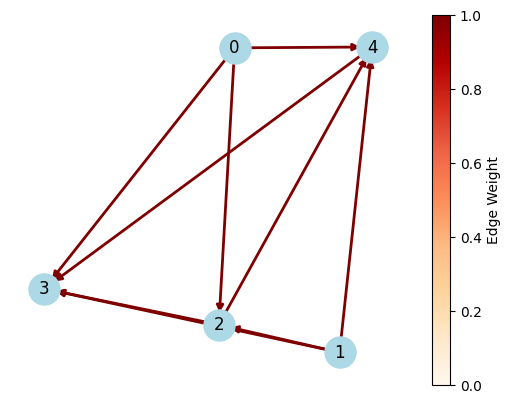

In [16]:
nx.draw_networkx_nodes(graph, pos, node_color='lightblue', node_size=500)
nx.draw_networkx_labels(graph, pos)
nx.draw_networkx_edges(graph, pos, edge_color=weights, edge_cmap=plt.cm.OrRd, edge_vmin=0, edge_vmax=1, width=2)
plt.colorbar(plt.cm.ScalarMappable(plt.Normalize(0, 1), plt.cm.OrRd), ax=plt.gca(), label='Edge Weight')
plt.axis('off')
plt.show()